In [1]:
import json
import os
import sys
import glob
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
sys.path.append(os.path.join(sys.path[0], '../tooling/'))
from myeval import myevaluatemodels
from mymodels import cascade_classifier

Collect statistics

In [3]:
location = '../results/train_vj/'
load_dirs = glob.glob(os.path.join(location,'*.json'))

In [4]:
params = [name[32:-11] for name in load_dirs]
stages = np.sort(np.unique([name[:name.find("_")] for name in params]).astype('float64'))
alarms = np.sort(np.unique([name[1+name.find("_"):] for name in params]).astype('float64'))

In [5]:
train_scores = np.zeros([alarms.shape[0],stages.shape[0]])
val_scores = np.zeros_like(train_scores)
for i, alarm in enumerate(alarms):
    for j, stage in enumerate(stages):
        model = 'ballcascade_' + str(round(stage)) + '_' + str(alarm)
        dir = location + model + '_stats.json'
        with open(dir, 'r') as input_file:
            read_dict = json.load(input_file)
        if "coco_train_sml_01_False_matchdrill" in read_dict[model]:
            train_scores[i,j] = read_dict[model]['coco_train_sml_01_False_matchdrill']['AP_{@[IoU=0.50:0.95]-all}'] 
        if "coco_validation_sml_01_False_matchdrill" in read_dict[model]:
            val_scores[i,j] = read_dict[model]['coco_validation_sml_01_False_matchdrill']['AP_{@[IoU=0.50:0.95]-all}']        

Plot all detectors

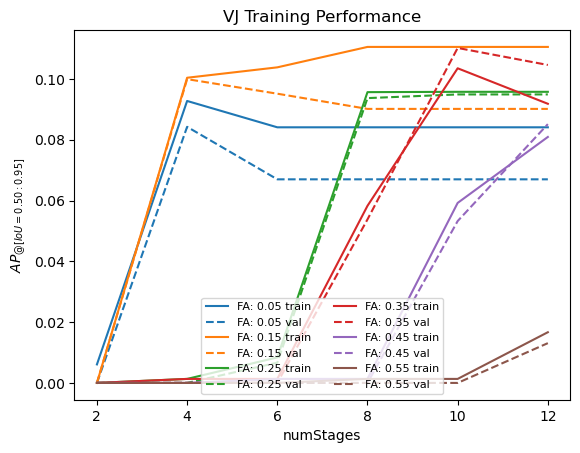

In [6]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
leg_list = []
for i, train_score in enumerate(train_scores):
    plt.plot(stages, train_scores[i], linestyle='-', color=colors[i])
    leg_list.append("FA: " + str(alarms[i]) + " train")
    plt.plot(stages, val_scores[i], linestyle='--', color=colors[i])
    leg_list.append("FA: " + str(alarms[i])+ " val")

plt.legend(leg_list, loc="lower center", fontsize="8", ncol=2)
plt.xlabel("numStages")
plt.ylabel("$" + "AP_{@[IoU=0.50:0.95]}" + "$")
plt.title("VJ Training Performance")
plt.show()

Fine tune

In [ ]:
scales = np.linspace(1, 1.5, 11)[1:]
neighbours = np.arange(1,6)
chosen_model = '../models/vj/ballcascade_10_0.35.xml'
dataset = "../data/coco_validation_sml_01_False_matchdrill/"
result_dir = "../results/tune_vj/"

for scale in scales:
    for neighbour in neighbours:
        evaluate_model = [[chosen_model, cascade_classifier, {"scale_factor":scale, "min_neighbours":neighbour}]]
        evaluate_dataset = [dataset]
        myevaluatemodels(evaluate_model, evaluate_dataset, result_dir, verbose=True)
